# COMP90051 Workshop 3
## Part 1: Linear regression

***

In this part, we'll explore ordinary least squares (OLS) regression. Our key objectives are:

* to implement OLS regression using numerical linear algebra functions from the `numpy` library
* to practice using the scikit-learn interface for linear regression

Firstly, we'll import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108

### 1.1. The Boston Housing dataset

Throughout this worksheet, we'll use the _Boston Housing dataset_ as an example. 
It contains data about towns in the Boston area, which can be used to predict median house values. 
There are 506 observations in total, each of which is described by 13 features, such as _per capita crime rate_, _percentage of population with a lower socio-economic status_, etc. 
You can read more about the features [here](http://lib.stat.cmu.edu/datasets/boston).

Let's begin by loading the data (from scikit-learn) and converting to a Pandas dataframe.

In [2]:
from sklearn.datasets import load_boston
# Note the version of sklearn should be scikit-learn==1.1.3, otherwise the dataset may not be avaliable.
boston = load_boston()
ds = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target, name='MEDV')
ds.head()

d:\Applications\Miniconda3\envs\sml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


To keep things simple, we'll work with a single feature called `LSTAT` for now. 
It corresponds to the percentage of the population in the town classified as 'lower status' by the US Census service in 1978. 
Note that the response variable (the median house value in the town) is denoted `MEDV`.
Plotting the  `MEDV` vs. `LSTAT` we see that a linear model appears plausible:

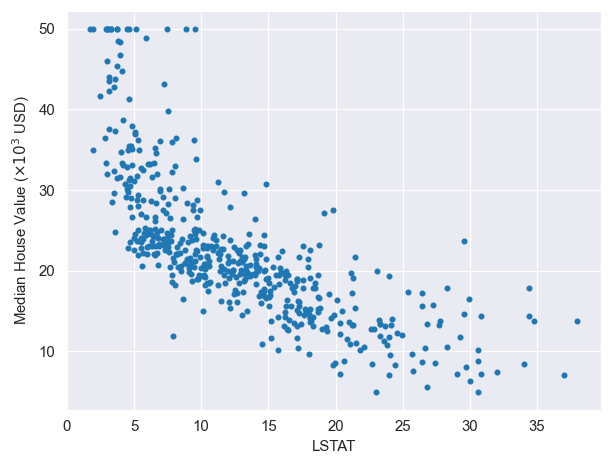

In [3]:
features = ['LSTAT']

#ds['LSTAT'] = ds['LSTAT'].apply(lambda x: x/100.)
for f in features:
    plt.figure()
    plt.scatter(ds[f], y, marker='.')
    plt.xlabel(f)
    plt.ylabel(r'Median House Value ($\times 10^3$ USD)')

***
**Question:** Have we made any mistakes in our analysis so far?

_Answer: Yes, a minor one. It's important that the model development process is not informed at all by the test data.
Technically, we shouldn't even visualise the test data, in case any observed trends/patterns inform our choice of model._
***

Let's now randomly split the data into training and test sets.
This is necessary, so we can assess the generalisation error of our model later on.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds, y, test_size=0.2, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))
# select subset of the features
X_train_s = X_train[features].values
X_test_s = X_test[features].values

Training set has 404 instances. Test set has 102 instances.


### 1.2. Linear algebra solution

Let's now fit a linear regression model to the single-featured Boston Housing data. 
In order to appreciate the lower-level details, we'll start by fitting the model using numerical linear algebra functions. 
The same approach is used under the hood in machine learning libraries, such as scikit-learn.

***
**Exercise:** In lectures, we derived an analytic expression for the optimal weights $\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$. Attempt the derivation yourself using the following matrix calculus identities: 

$$
\begin{gather}
    \nabla_{\mathbf{w}} \mathbf{w}^\top \mathbf{x} = \nabla_{\mathbf{w}} \mathbf{x}^\top \mathbf{w} = \mathbf{x}^\top \\
    \nabla_{\mathbf{w}} \mathbf{A}\mathbf{w} = \mathbf{A} \\
    \nabla_{\mathbf{w}} \mathbf{w}^\top \mathbf{A}\mathbf{w} = \mathbf{w}^\top \left(\mathbf{A}^\top + \mathbf{A}\right)
\end{gather}
$$

where vector $\mathbf{x}$ and matrix $\mathbf{A}$ are constants (independent of $\mathbf{w}$).

**Solution:**
Under a decision theoretic framework, the empirical risk can be expressed as 
$$
\hat{R}(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^{n} (\mathbf{x}_i^\top \mathbf{w} - y_i)^2  = \|\mathbf{X} \mathbf{w} - \mathbf{y}\|_2^2 = \mathbf{w}^\top \mathbf{X}^\top \mathbf{X} \mathbf{w} - \mathbf{w}^\top \mathbf{X}^\top \mathbf{y}  - \mathbf{y}^\top \mathbf{X} \mathbf{w} + \mathbf{y}^\top \mathbf{y}
$$
where 
$\mathbf{X} = \begin{pmatrix} \mathbf{x}_1^\top \\ \mathbf{x}_2^\top \\ \vdots \\ \mathbf{x}_n^\top \end{pmatrix}$ is the _design matrix_, 
$\mathbf{y} = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{pmatrix}$ and 
$\mathbf{w} = \begin{pmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{pmatrix}$.

The optimal weight vector is a minimiser of the empirical risk, i.e. $\mathbf{w}^\star \in \arg \min_{\mathbf{w}} \hat{R}(\mathbf{w})$. 
To get the _normal equations_ we solve for the stationary points of $\hat{R}(\mathbf{w})$, i.e. $\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}) = 0$.
We have

$$
\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}) = \nabla_{\mathbf{w}} (\mathbf{w}^T \mathbf{X}^\top \mathbf{X} \mathbf{w}) - \nabla_{\mathbf{w}} ( \mathbf{w}^\top \mathbf{X}^\top \mathbf{y}) - \nabla_{\mathbf{w}} (\mathbf{y}^\top \mathbf{X} \mathbf{w}) = 2 \mathbf{w}^\top \mathbf{X}^\top \mathbf{X} - 2 \mathbf{y}^\top \mathbf{X}
$$

which implies $\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$
***

Although we can express $\mathbf{w}^\star$ explicitly in terms of the matrix inverse $(\mathbf{X}^\top \mathbf{X})^{-1}$, this isn't an efficient way to compute $\mathbf{w}$ numerically (we typically never compute the inverse of a matrix exactly when solving the system $A\mathbf{x} = b$ for numerical stability). It is better instead to solve the following system of linear equations:
$$\mathbf{X}^\top\mathbf{X} \mathbf{w}^\star = \mathbf{X}^\top\mathbf{y}$$

***
**Exercise:** Use `np.linalg.solve` to solve for $\mathbf{w}^\star$ using the single-featured training data.
_Hint: You can enter `np.linalg.solve?` or `help(np.linalg.solve)` to see the docstring (help file)._
***

In [5]:
# Prepend a column of 1's to the design matrices (since we absorbed the bias term in the weights vector)
X_train_b = np.column_stack((np.ones_like(X_train_s), X_train_s))
X_test_b = np.column_stack((np.ones_like(X_test_s), X_test_s))
print('Design matrix shape:', X_train_s.shape)

w = np.linalg.solve((X_train_b.T @ X_train_b), (X_train_b.T @ y_train)) # fill in matmul @ np.dot
print('Weights:', w)

# @ matmul np.dot()

Design matrix shape: (404, 1)
Weights: [34.51530004 -0.95801769]


Let's check our implementation by plotting the predictions on the test data.

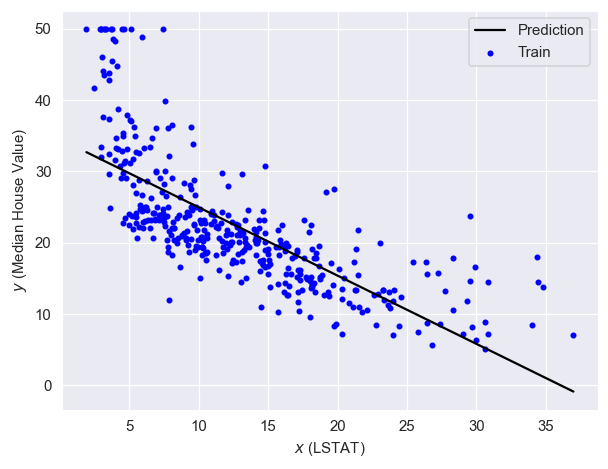

In [6]:
def predict(X, w):
    """Return the predicted response for a given design matrix and weights vector
    """
    return np.dot(X, w)

X_grid = np.linspace(X_train_s.min(), X_train_s.max(), num=1001)
x = np.column_stack((np.ones_like(X_grid), X_grid))
y = predict(x, w)
plt.plot(X_grid, y, 'k-', label='Prediction')
plt.scatter(X_train_s, y_train, color='b', marker='.', label='Train')
#plt.scatter(X_test_s, y_test, color='r', marker='.', label='Test')
plt.legend()
plt.ylabel("$y$ (Median House Value)")
plt.xlabel("$x$ (LSTAT)")
plt.show()

We'll compute the mean error term over the training and test sets to assess model performance.

In [7]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true)**2) 

y_pred_train = predict(X_train_b, w)
y_pred_test = predict(X_test_b, w)
print('Train MSE:', mean_squared_error(y_pred_train, y_train))
print('Test MSE:', mean_squared_error(y_pred_test, y_test))

Train MSE: 38.632216441608094
Test MSE: 38.00420488101304


### 1.3. Linear regression using scikit-learn

Now that you have a good understanding of what's going on under the hood, you can use the functionality in scikit-learn to solve linear regression problems you encounter in the future. Using the `LinearRegression` module, fitting a linear regression model becomes a one-liner as shown below.

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_s, y_train)

The `LinearRegression` module provides access to the bias weight $w_0$ under the `intercept_` property

In [9]:
lr.intercept_

34.5153000408642

and the non-bias weights under the `coef_` property

In [10]:
lr.coef_

array([-0.95801769])

You should check that these results match the solution you obtained previously. Note that sklearn also uses a numerical linear algebra solver under the hood.

Finally, what happens if we use the other 12 features available in the dataset? To make predictions, we can utilize the `predict` API. Scikit-learn also includes an implementation of the `mean_squared_error` function that we can import and employ to assess our implementation.

In [11]:
lr_full = LinearRegression().fit(X_train, y_train)
y_pred_train = lr_full.predict(X_train)
y_pred_test = lr_full.predict(X_test)

print('Train MSE:', mean_squared_error(y_pred_train, y_train))
print('Test MSE:', mean_squared_error(y_pred_test, y_test))

Train MSE: 20.059284291202285
Test MSE: 30.72694987338846


d:\Applications\Miniconda3\envs\sml\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\Applications\Miniconda3\envs\sml\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\Applications\Miniconda3\envs\sml\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\Applications\Miniconda3\envs\sml\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [12]:
from sklearn.metrics import mean_squared_error as sk_mse
print('Train MSE:', sk_mse(y_pred_train, y_train))
print('Test MSE:', sk_mse(y_pred_test, y_test))

Train MSE: 20.059284291202285
Test MSE: 30.72694987338846


As measured by the MSE, our predictions are looking better. Although we obtained a performance boost here, in real problems you should be cautious of blindly including features in your analysis just because you can.

## Part 2: Logistic regression

***

In this part, we'll implement logistic regression from scratch using the gradiant descent. 

Firstly, we'll import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
# RND_SEED = 90051
RND_SEED = 0

### 2.1. Binary classification data

Let's begin by generating some binary classification data.
To make it easy for us to visualise the results, we'll stick to a two-dimensional feature space.

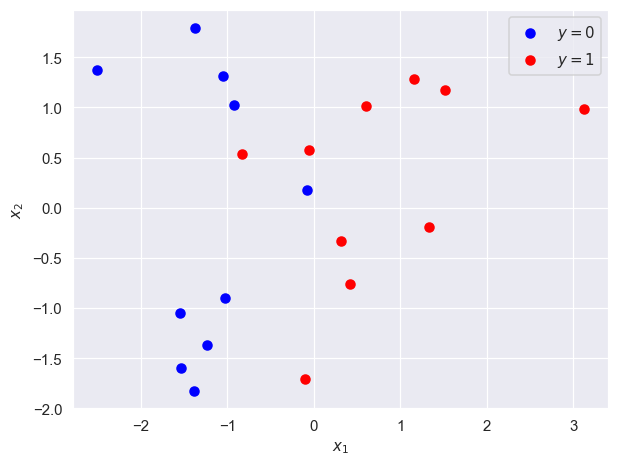

In [14]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 20, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==0,0], X[y==0,1], color='b', label="$y = 0$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

***
**Question:** What do you notice about the data? It is possible for logistic regression to achieve perfect accuracy on this data?

_Answer: the data isn't linearly separable, which means a linear classifier cannot achieve perfect accuracy._
***

### 2.2. Logistic regression

Recall that logistic regression assumes a linear relationship between the features $\mathbf{x}$ and the log-odds of the event $Y = 1$:

$$
\log \frac{p(y = 1|\mathbf{x})}{1 - p(y = 1|\mathbf{x})} = \mathbf{x}^\top \mathbf{w}.
$$

From a decision-theoretic point of view, we choose the weights vector $\mathbf{w}$ to minimise the empirical risk under the log-loss (a.k.a. cross-entropy loss and logistic loss):

$$
\hat{R}(\mathbf{w}) = - \frac{1}{n} \sum_{i = 1}^{n} \ell_\mathrm{log}(y_i, \mu_i(\mathbf{w})),
$$

where $\ell_\mathrm{log}(y, \mu) = y \log \mu + (1 - y) \log (1 - \mu)$ and  $\mu_i(\mathbf{w}) := \frac{1}{1 + \exp( - \mathbf{x}_i^\top \mathbf{w})}$.

We'll need to evaluate $\hat{R}(\mathbf{w})$ later on to generate convergence plots, so we define a function for this below.

In [15]:
from sklearn.metrics import log_loss

def risk(X, y, w):
    """Evaluate the empirical risk under the cross-entropy (logistic) loss
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Weight vector.
    
    Returns
    -------
    risk : float
    """
    mu = expit(X @ w)
    return log_loss(y, mu)

### 2.3. Logistic regression via gradient descent



"The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent."

To do this, we need two steps:
* compute the _gradient_ of the empirical risk $\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}')$
* update the weights in the opposite direction of the gradient

It's straightforward to show (using vector calculus) that:

$$
\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^{n} (\mu_i(\mathbf{w}) - y_i)\mathbf{x}_i = \frac{1}{n} \mathbf{X}^\top (\boldsymbol{\mu} - \mathbf{y}),
$$

where $\boldsymbol{\mu} = \begin{pmatrix} \mu_1(\mathbf{w}) \\ \vdots \\ \mu_n(\mathbf{w}) \end{pmatrix}$.

***
**Exercise:** Complete the `grad_risk` function below, which computes $\nabla_{\mathbf{w}} \hat{R}(\mathbf{w})$ for a given weight vector $\mathbf{w}$ and training data $\mathbf{X}$ and $\mathbf{y}$.
***

In [16]:
def grad_risk(X, y, w):
    """Evaluate the gradient of the empirical risk
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Weight vector.
    
    Returns
    -------
    grad_w : array of shape (n_features,)
    """
    # fill in
    mu = expit(X @ w)
    grad_w = X.T @ (mu - y) / X.shape[0]
    return grad_w

# Test case
if RND_SEED == 0:
    test_grad_risk_actual = grad_risk(X_b, y, np.ones(3))
    test_grad_risk_desired = np.array([0.11641865, -0.25260051, 0.20606407])
    np.testing.assert_allclose(test_grad_risk_actual, test_grad_risk_desired)

Recall that the weight update for gradient descent at iteration $t$ is given by:

$$
\mathbf{w}_t = \mathbf{w}_{t - 1} - \eta \nabla_\mathbf{w} \hat{R}(\mathbf{w}_{t - 1})
$$

where $\eta > 0$ is a learning rate parameter.
***
**Exercise:** Complete the `update_weight_gd` function below which implements the weight update for gradient descent.
***

In [17]:
def update_weight_gd(X, y, w, **kwargs):
    """Performs a gradient descent weight update
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
    
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Current estimate of the weight vector.
    
    **kwargs : 
        Keyword arguments.
        
    Returns
    -------
    w : array of shape (n_features,)
        Updated estimate of the weights vector.
    """
    # Get learning rate from kwargs, defaulting to 1.0 if None
    eta = kwargs.get("eta", 1)
    return w - eta * grad_risk(X, y, w) # fill in

Now that we've implemented `grad_risk` and `update_weight_gd`, we're very close to being able to run gradient descent.
We just need to write some code to:

* initialise the weight vector, and
* iterate until the stopping criterion $\| \nabla_\mathbf{w} \hat{R}(\mathbf{w}_t) \|_\infty \leq \mathtt{tol}$ is satisfied (or a max number of iterations is completed).

We do this in the `fit_logistic` function below. 
Note that we treat the `update_weight` function as a parameter, which defaults to gradient descent. 

In [18]:
def fit_logistic(X, y, w_init=None, max_iter = 100, tol = 1e-9, 
                 update_weight = update_weight_gd, **kwargs):
    """Fits a binary logistic regression model according to the given training 
    data
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to `X`. Binary classes must be encoded as 0 and 1.
    
    w_init : array of shape (n_features,) default=None
        Initial guess for the weights vector. Defaults to a vector of
        zeroes.
    
    max_iter : int, default=100
        Maximum number of iterations
    
    tol : float, default=1e-4
        Stop when the inf-norm of the gradient falls below this value.
    
    update_weight : callable, default=update_weight_gd
        Callable that performs a weight update. Must have signature 
        (X, y, w, **kwargs). Defaults to GD.
    
    **kwargs : 
        Keyword arguments passed to `update_weight`.
    
    Returns
    -------
    w_history : list of arrays of shape (n_features,)
        History of weight vectors
    """
    if w_init is None:
        # Default weight initialisation
        w_init = np.zeros(X.shape[1], dtype=float)
        
    # Store history of weights
    w_history = [w_init]
    w = w_init
    
    for t in range(max_iter):
        w = update_weight(X, y, w, **kwargs)
        w_history.append(w)
        
        # Check stopping criterion
        grad_inf = np.linalg.norm(grad_risk(X, y, w), ord=np.inf)
        if grad_inf <= tol:
            break
    
    print("Stopping after {} iterations".format(t))
    print("Inf-norm of grad is {:.4g}".format(grad_inf))
    
    return w_history

Let's run the algorithm on the 2D classification data we generated in Section 1 and visualise the result. Does the result look reasonable?

Stopping after 210 iterations
Inf-norm of grad is 9.775e-10


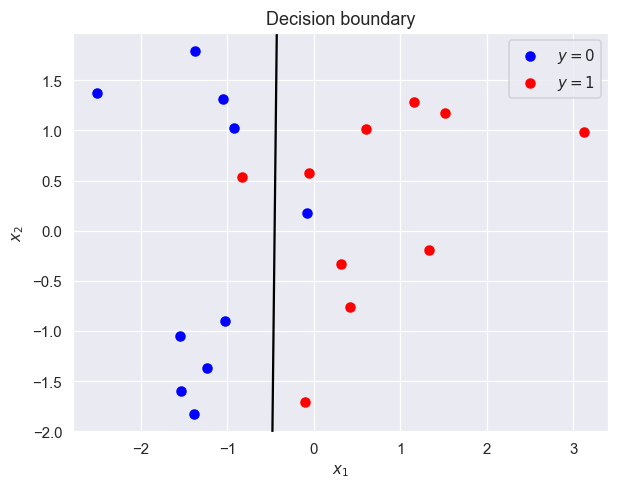

In [19]:
w_history_gd = fit_logistic(X_b, y, max_iter = 1000, tol = 1e-9, eta = 5)

def plot_decision_boundary(X, y, w):
    """Plots the decision boundary of a logistic regression classifier defined 
    by weights `w`
    """
    fig, ax = plt.subplots()
    ax.scatter(X_b[y==0,1], X_b[y==0,2], color='b', label="$y = 0$")
    ax.scatter(X_b[y==1,1], X_b[y==1,2], color='r', label="$y = 1$")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(list(xlim), [-w[0]/w[2] - w[1]/w[2] * x for x in xlim], ls = "-", color="k")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title("Decision boundary")
    ax.legend()
    plt.show()

plot_decision_boundary(X_b, y, w_history_gd[-1])

Let's take a look at the path taken by the Gradient Descent algorithm to reach the optimal solution.
We plot the weight vectors at each iteration $\mathbf{w}_0, \mathbf{w}_1, \ldots$ on top of contours of the empirical risk $\hat{R}(\mathbf{w})$. 
The darker the shade, the lower the empirical risk.

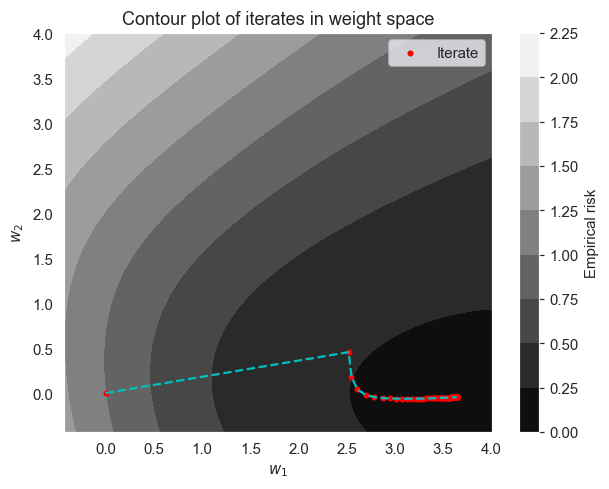

In [20]:
def plot_iterates(X, y, w_history):
    """Plots the path of iterates in weight space (excluding the bias)"""
    w_history = np.array(w_history)
    
    # Compute axes limits
    w12_max = w_history[:,1:].max()
    w12_min = w_history[:,1:].min()
    w12_ran = w12_max - w12_min
    border = 0.1
    
    # Compute objective on grid
    w12 = np.linspace(w12_min - border * w12_ran, w12_max + border * w12_ran, num=100)
    w1v, w2v = np.meshgrid(w12, w12)
    w12v = np.c_[w1v.ravel(), w2v.ravel()]
    z = np.array([risk(X_b, y, np.r_[w_history[-1][0], w12]) for w12 in w12v])
    z = z.reshape(w1v.shape)

    plt.contourf(w1v, w2v, z, cmap='gist_gray')
    plt.colorbar(label='Empirical risk')
    plt.plot(w_history[:,1], w_history[:,2], c='c', ls='--')
    plt.scatter(w_history[:,1], w_history[:,2], c='r', marker='.', label='Iterate')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    plt.legend()
    plt.title('Contour plot of iterates in weight space')
    plt.show()

plot_iterates(X_b, y, w_history_gd)

We can also check the validity of our implementation by comparing with scikit-learn's implementation. Note that the scikit-learn implementation incorporates $L_2$ regularisation by default, so we need to switch it off by setting `penalty = 'none'`.

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='none')
clf.fit(X, y)
w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
print("Weights according to ours: {}".format(w_history_gd[-1]))
print("Weights according to scikit-learn: {}".format(w_sklearn))

Weights according to ours: [ 1.64777582  3.63949087 -0.04606749]
Weights according to scikit-learn: [ 1.64777385  3.63947254 -0.04607371]
